In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


In [2]:
def DeepConvNet(nb_classes, Chans = 60, Samples = 151, dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)




In [3]:
## trainer 

import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
# from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
data_path = sample.data_path()

# Set parameters and read data
raw_fname = str(data_path) + '\MEG\sample\sample_audvis_filt-0-40_raw.fif'
event_fname = str(data_path) + '\MEG\sample\sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
labels = epochs.events[:, -1]

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 60, 151




Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB



In [12]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = y[0:144]
X_validate   = X[144:216,]
Y_validate   = y[144:216]
X_test       = X[216:,]
Y_test       = y[216:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train-1)
Y_validate   = np_utils.to_categorical(Y_validate-1)
Y_test       = np_utils.to_categorical(Y_test-1)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')


X_train shape: (144, 60, 151, 1)
144 train samples
72 validate samples
72 test samples


In [5]:
model = DeepConvNet(nb_classes = 4, Chans = 60, Samples = 151, dropoutRate = 0.5)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='checkpoint1.h5', verbose=1,
                               save_best_only=True)

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)

# load optimal weights
model.load_weights('checkpoint1.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 151, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 60, 147, 25)       150       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 147, 25)        37525     
                                                                 
 batch_normalization (Batch  (None, 1, 147, 25)        100       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1, 147, 25)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 73, 25)         0         
 D)                                                          

c:\Users\sandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 1.40533
9/9 - 0s - loss: 1.5083 - accuracy: 0.2778 - val_loss: 1.4225 - val_accuracy: 0.2639 - 315ms/epoch - 35ms/step
Epoch 3/300

Epoch 3: val_loss improved from 1.40533 to 1.40323, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.4386 - accuracy: 0.3403 - val_loss: 1.4032 - val_accuracy: 0.2639 - 338ms/epoch - 38ms/step
Epoch 4/300

Epoch 4: val_loss improved from 1.40323 to 1.38113, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.2882 - accuracy: 0.3472 - val_loss: 1.3811 - val_accuracy: 0.2917 - 354ms/epoch - 39ms/step
Epoch 5/300

Epoch 5: val_loss improved from 1.38113 to 1.35471, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.2131 - accuracy: 0.4167 - val_loss: 1.3547 - val_accuracy: 0.3472 - 331ms/epoch - 37ms/step
Epoch 6/300

Epoch 6: val_loss improved from 1.35471 to 1.31792, saving model to checkpoint1.h5
9/9 - 0s - loss: 1.1726 - accuracy: 0.4653 - val_loss: 1.3179 - val_accuracy: 0.3750 - 304ms/epoch - 34ms/step
Epoch 7/300



In [6]:
X_test[0].shape

(60, 151, 1)

In [7]:
# make prediction on test set.

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 8ms/step
Classification accuracy: 0.833333 


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from joblib import dump, load

 Evaluation:
Accuracy: 0.83
Precision: 0.84
Recall: 0.83




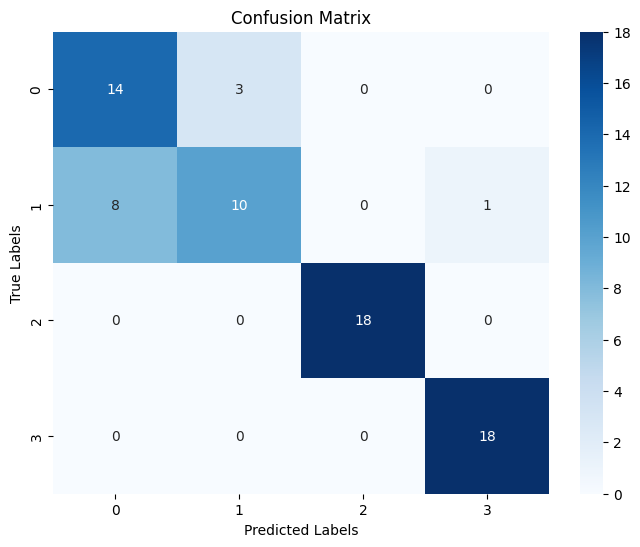

In [9]:
temp = Y_test.argmax(axis=-1)
conf_matrix = confusion_matrix(temp, preds)
accuracy = accuracy_score(temp, preds)
precision = precision_score(temp, preds, average='weighted')
recall = recall_score(temp, preds, average='weighted')

print(f" Evaluation:")
dump(model, 'shallowConvNet.joblib')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [10]:
model.predict(X_test).argmax(axis = -1)  

3/3 [==============================] - 0s 7ms/step


array([3, 1, 2, 1, 3, 0, 2, 1, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 0, 2,
       0, 3, 0, 2, 3, 1, 2, 0, 3, 0, 2, 0, 3, 1, 2, 0, 3, 0, 2, 1, 3, 1,
       2, 0, 2, 0, 3, 1, 2, 0, 3, 3, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 0,
       0, 3, 0, 2, 0, 3], dtype=int64)

In [11]:
Y_test.argmax(axis=-1)

array([3, 1, 2, 0, 3, 1, 2, 0, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2,
       0, 3, 1, 2, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1,
       2, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 0, 3, 1,
       0, 3, 1, 2, 0, 3], dtype=int64)